<a href="https://colab.research.google.com/github/GRVite/pynacollada/blob/main/Generalized_Linear_Model_for_neural_crosscorrelations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Pynacollada Tutorial Series
#@markdown Generalized Linear Model for neural crosscorrelations

In [17]:
#@markdown Objective: Compute crosscorrelations between a couple of neurons using a Generalized Linear Model (GLM).
#@markdown <br> - Crosscorrelations of the spike trains help you to figure it out if neurons fire together or not. 
#@markdown However, among a population of neurons, it is hard to distinguish if a couple of neurons in that population are coordinated between themselves or are actually coupled to the overral activity of the population.
#@markdown <br> To overcome this issue, crosscorrelations based on GLM are very useful to disambiguate the coupling of a given neuron
#@markdown with respect another neuron and the population. All you need is:

#@markdown - the spike trains of your reference neuron, neuron A (Y),
#@markdown - the spike trains of neuron B (X1) 
#@markdown - and the spike trains of the population to which neuron A belongs (X2)

#@markdown <br> The result that you get from this script are values (betas) 
#@markdown that indicate degree of correlation between neuron B and cell A (betas_cellB in this notebook), and between
#@markdown the population and cell A (betas_pop).

SyntaxError: ignored

In [2]:
# Pynapple needs to be instaled manually when you use Google Collab
!pip install pynapple

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 86 kB 4.1 MB/s 
     |████████████████████████████████| 995 kB 32.5 MB/s 
     |████████████████████████████████| 115 kB 44.1 MB/s 
     |████████████████████████████████| 8.3 MB 31.6 MB/s 
     |████████████████████████████████| 185 kB 44.8 MB/s 
     |████████████████████████████████| 109 kB 45.3 MB/s 
     |████████████████████████████████| 546 kB 40.0 MB/s 
     |████████████████████████████████| 338 kB 46.8 MB/s 
     |████████████████████████████████| 59.9 MB 90 kB/s 


In [3]:
import pynapple as nap
import matplotlib.pyplot as plt
from math import ceil
import numpy as np 
import pandas as pd
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
#@title Setting up
from google.colab import drive
drive.mount('/content/drive')
dir = '/content/drive/MyDrive/Pynacollada'
session = '/B0702-211111'
data_directory = dir + session 
print("loading data from " + data_directory)

Mounted at /content/drive
loading data from /content/drive/MyDrive/Pynacollada/B0702-211111


In [5]:
#First, let's load the data
data = nap.load_session(data_directory, 'neurosuite')
spikes = data.spikes
epochs = data.epochs

/usr/local/lib/python3.7/dist-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


In [6]:
# The first thing you need to do is to bin your spikes
binsize = 0.04 # s |If the animal is awake a binsize of 40ms -300ms can work, you need to play with this
# Use the pynapple built-in function to count the numbers of spikes per bin
rate = spikes.count(binsize, ep = epochs['wake'].iloc[[0]])

In [7]:
# Parameters for running the GLM
sigma = 1 # s | for the smoothing window
lag = 10 # s | extend of the crosscorrelogram 
binsize_wake = tau = 0.04 # s | for binning your spikes  and for the sliding window
# create the time lag extent based on the binsize defined (e.g. -10s to +10s)
time_lag = np.arange(-lag, lag+tau, tau) 
# transform it to the number of bins that you are actually going to extract
shift = time_lag//binsize_wake 
shift = shift.astype('int')


In [8]:
# Run the glm for a couple of neurons and plot the results
p = (2,10) # the first neuron is the one you want to model
# This is a recording in the medial entorhinal cortex so the population is equal to all the neurons
population_indexes = [*spikes]
# Select the data corresponding to the population of cell A
y = pd.DataFrame(index=rate.index, data=rate[p[0]].values).rolling(
    window=int(sigma/binsize), win_type='gaussian', 
    center= True, min_periods=1).mean(std = 3).values.ravel()
cells2drop = [p[0]] 
population_indexes.remove(p[0]) #drop the cell that will be modelled
pop = rate.drop(labels=[p[0]], axis=1)[population_indexes]


In [9]:
# create population vector by summing all the counts
x1 = pop.sum(axis=1).rolling(window=int(sigma//binsize), 
                              win_type='gaussian', center= True, 
                              min_periods=1).mean(std = 1)
# select data of cell B and smooth it
x2 = pd.DataFrame(index = rate.index, data = rate[p[1]].values).rolling(
    window=int(sigma//binsize), win_type='gaussian', 
    center= True, min_periods=1).mean(std = 1)
# let's put the data from the population and from cell B together
x = pd.concat([x1,x2], axis = 1)
# and normalize it 
x = (x - x.mean())/x.std() 


In [12]:
 # now we'll create a list for the betas corresponding to cell B
betas_cellB = []
# and a list for the betas of the population
betas_pop = [] 
# in the next loop we take cell A as a target and we will shift the spike counts
for s in shift:
    if s < 0 : 
        Y = y[-s:] 
        X = x.iloc[:s]
    elif s > 0 : 
        Y = y[:-s]
        X= x.iloc[s:]
    else:
        X = x
        Y = y
    model= sm.GLM(Y, X.values, family=sm.families.Poisson())
    r = model.fit(link=sm.genmod.families.links.Log)
    betas_cellB.append(r.params[1])
    betas_pop.append(r.params[0])

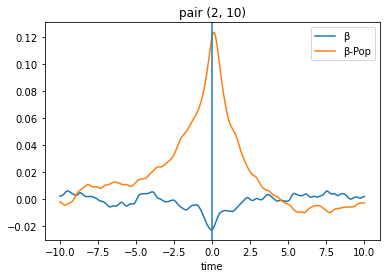

In [14]:
plt.figure()
plt.plot(time_lag, betas_cellB)
plt.plot(time_lag, betas_pop)
plt.axvline(0)
plt.xlabel("time")
plt.title('pair ' + str(p))
plt.legend(["\u03B2", "\u03B2-Pop"])
plt.show()